# Comparing Explanation Methods with deit_tiny_finetuned

This notebook loads a finetuned deit_tiny_patch16_224 model (with a custom head and weights), then runs several explanation methods on each image from a dataset (e.g., COVID-Q). It creates a composite image comparing the different explanation masks.



deit_tiny_finetuned
Found 583 images.
1649


/users/eleves-b/2022/edouard.rabasse/.local/lib/python3.9/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/users/eleves-b/2022/edouard.rabasse/.local/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


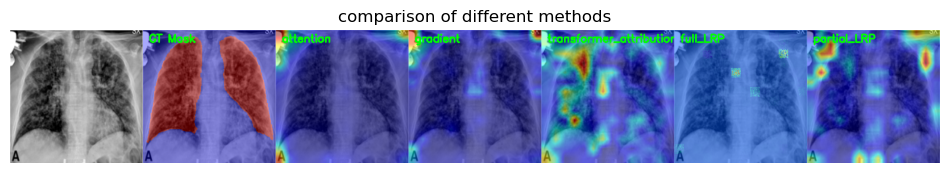

In [2]:
import os
import glob
import cv2
import json
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from types import SimpleNamespace
# Import your explanation functions and model loading functions
# Adjust these imports to point to your modules
from vit_explain_modulable import run_explanation, load_model, show_mask_on_image
# from load_deit import load_deit  # if used in your fine-tuning function

# Custom finetuned model loader


# A helper function to create a composite image from the original and masks
# def create_composite(original_img, results_dict):
#     orig = np.array(original_img)  # in RGB
#     orig = cv2.cvtColor(orig, cv2.COLOR_RGB2BGR)
#     orig = cv2.resize(orig, (224, 224))

    
#     composite_images = [orig]
#     for method, mask in results_dict.items():
#         m = cv2.resize(mask, (orig.shape[1], orig.shape[0]))
#         overlay = show_mask_on_image(orig, m)
#         cv2.putText(overlay, method, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
#         composite_images.append(overlay)
#     comp = np.hstack(composite_images)
#     return comp

def create_composite(original_img, results_dict, gt_mask=None, lung_mask=None):
    """
    Create a composite image with the original image and the explanation overlays.
    Optionally, include additional masks (e.g. ground truth or lung segmentation).
    
    Args:
        original_img: the original image as a PIL image.
        results_dict: a dictionary where keys are method names and values are explanation masks.
        gt_mask: (optional) a ground truth segmentation mask (binary, 0 or 1).
        lung_mask: (optional) a lung segmentation mask (binary, 0 or 1).
        
    Returns:
        A composite image (NumPy array) with all overlays.
    """
    # Convert original image to BGR (for OpenCV display) and resize to 224x224.
    orig = np.array(original_img)
    orig = cv2.cvtColor(orig, cv2.COLOR_RGB2BGR)
    orig = cv2.resize(orig, (224, 224))
    
    panels = [orig]
    
    # If provided, add the ground truth mask overlay.
    if gt_mask is not None:
        # Assume gt_mask is a NumPy array of shape (H, W) with values 0 or 1.
        gt_overlay = show_mask_on_image(orig, gt_mask)
        cv2.putText(gt_overlay, "GT Mask", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        
        panels.append(gt_overlay)
        
    # Similarly, add the lung mask overlay if provided.
    if lung_mask is not None:
        lung_overlay = show_mask_on_image(orig, lung_mask)
        cv2.putText(lung_overlay, "Lung Mask", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        panels.append(lung_overlay)
        
    # For each explanation method, overlay its mask.
    for method, mask in results_dict.items():
        m = cv2.resize(mask, (orig.shape[1], orig.shape[0]))
        overlay = show_mask_on_image(orig, m)
        cv2.putText(overlay, method, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        panels.append(overlay)
    
    # Stack images horizontally.
    composite = np.hstack(panels)
    return composite


# Define a dictionary of methods to compare
methods = ["attention", "gradient", "transformer_attribution", "full_LRP","partial_LRP"]

# Parameters for the model, as a dictionary (this was originally passed as a JSON string)
model_parameters = {"pretrained": True, "weights_path": "weights/deit_tiny_head_weights.pth"}

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Transformation for the input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Create a dummy args dictionary (simulate command-line arguments)
args_dict = {
    "category_index": None,
    "discard_ratio": 0.9,
    "head_fusion": "mean",
    "attention_layer_name": "attn_drop",
    "model_name": "deit_tiny_finetuned",
    "use_cuda": True,
}

args = SimpleNamespace(**args_dict)

# Load the finetuned model
model = load_model(args.model_name, model_parameters)
model = model.to(device)
model.eval()


# %% [markdown]
# ## Process Images and Compare Explanation Methods
# Loop over a subset of images from the dataset and generate composite images.

# Get list of images from dataset directory (adjust extension if necessary)
dataset_dir = "covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/images"  # update to your dataset directory
mask_dir = "covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/masks"  # update to your dataset directory
output_dir = "comparisons"
# dataset_dir = "examples"
os.makedirs(output_dir, exist_ok=True)
image_files = glob.glob(os.path.join(dataset_dir, "*.[jp][pn]g"))
image_files.sort()

print(f"Found {len(image_files)} images.")
# image_files = ["examples/a.png"]

# Process only a few images for demonstration (e.g., first 5 images)

image_numbers = [int(f.split("_")[1].split(".")[0]) for f in os.listdir("covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/images") if f.endswith(".png")]
print(image_numbers[2])


for img_number in image_numbers[1:2]:
    img_path = f"covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/images/covid_{img_number}.png"
    img = Image.open(f"covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/images/covid_{img_number}.png").convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)


    gt_mask_path = f"covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/infection masks/covid_{img_number}.png"   # ground truth segmentation mask
    gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
    # Normalize if necessary (e.g. if values are 0 and 255)
    if gt_mask.max() > 1:
        gt_mask = (gt_mask > 127).astype(np.uint8)
    gt_mask = cv2.resize(gt_mask, (224, 224))
    lung_mask_path = f"covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/lung masks/covid_{img_number}.png" # lung segmentation mask
    input_tensor = transform(img).unsqueeze(0).to(device)
    results = {}
    for method in methods:
        try:
            # Here, we assume run_explanation is defined and imported from your module
            from vit_explain_modulable import run_explanation
            mask, _ = run_explanation(method, model, input_tensor, args)
            # print output
            results[method] = mask
            # print(mask.shape)
        except Exception as e:
            print(f"Method {method} failed on {img_path}: {e}")
    
    # print(model(input_tensor).argmax().item(), method, mask.sum())

    # mask, _ = run_explanation("LRP_exact", model, input_tensor, args)
    composite = create_composite(img, results, gt_mask)
    base_name = os.path.basename(img_path)
    out_path = os.path.join(output_dir, f"composite_{base_name}")
    cv2.imwrite(out_path, composite)
    # print("Saved composite image to", out_path)
    plt.figure(figsize=(12,6))
    plt.imshow(cv2.cvtColor(composite, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    # plt.title(f"Comparison for {base_name}")
    plt.title("comparison of different methods")
    plt.show()


In [3]:
import cv2
import numpy as np


def create_mask_overlay(mask, gt_mask_path, lung_mask_path, threshold=0.5, resize_to_gt=True):
    """
    Create an RGB overlay image combining predicted mask (blue), ground-truth mask (red), and lung mask (green).
    
    Args:
        predicted_mask (np.array): Predicted mask (continuous or binary values).
        gt_mask_path (str): Path to ground truth infection mask (grayscale, 0/255 or 0/1).
        lung_mask_path (str): Path to lung segmentation mask (grayscale, 0/255 or 0/1).
        threshold (float): Threshold for binarizing the predicted mask.
        resize_to_gt (bool): If True, predicted_mask is resized to match GT mask shape.
    
    Returns:
        np.array: RGB overlay image with masks fused (float32 in range [0, 1]).
    """
    # # Binarize predicted mask
    # mask = (mask * 255).astype(np.uint8)
    # ret, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)
    # mask[mask == 255] = 1
    mask = (mask >= threshold).astype(np.uint8)
    
    # Load ground truth and lung masks
    gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
    lung_mask = cv2.imread(lung_mask_path, cv2.IMREAD_GRAYSCALE)
    
    # Normalize GT and lung masks to 0–1 range
    gt_mask = (gt_mask > 127).astype(np.float32)
    lung_mask = (lung_mask > 127).astype(np.float32)

    
    # Resize prediction if needed
    if resize_to_gt and mask.shape != gt_mask.shape:
        mask = cv2.resize(mask, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    # Create RGB overlays
    overlay = np.zeros((gt_mask.shape[0], gt_mask.shape[1], 3), dtype=np.float32)
    overlay[:, :, 0] = gt_mask       # Red: Ground truth
    overlay[:, :, 1] = lung_mask     # Green: Lung mask
    overlay[:, :, 2] = mask   # Blue: Prediction
    
    # Clip to ensure values in [0,1]
    overlay = np.clip(overlay, 0, 1)
    
    return overlay


def compute_mask_metric(mask, gt_mask_path, lung_mask_path, threshold=0.5):
    """
    Compute a metric by thresholding the predicted mask into 0/1,
    computing its intersection with the ground-truth segmentation (gt_mask),
    and then dividing by the area (number of pixels set to 1) in the lung segmentation.
    
    Args:
      predicted_mask (np.array): The continuous explanation mask (values between 0 and 1).
      gt_mask_path (str): Path to the ground-truth segmentation image (binary mask) for the same image.
      lung_mask_path (str): Path to the lung segmentation image (binary mask) for the same image.
      threshold (float): Threshold value to binarize the predicted mask.
      
    Returns:
      float: The ratio of intersection area to lung area.
    """
    # Threshold the predicted mask to obtain a binary mask
    mask = (mask >= threshold).astype(np.uint8)
    # mask = (mask * 255).astype(np.uint8)
    # ret, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # mask[mask == 255] = 1
    
    # Load the ground truth mask from disk; assume it is already binary (0 and 1)
    gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
    # Normalize if necessary (e.g. if values are 0 and 255)
    if gt_mask.max() > 1:
        gt_mask = (gt_mask > 127).astype(np.uint8)
    
    # Load the lung segmentation mask; assume it is binary (0 and 1)
    lung_mask = cv2.imread(lung_mask_path, cv2.IMREAD_GRAYSCALE)
    if lung_mask.max() > 1:
        lung_mask = (lung_mask > 127).astype(np.uint8)
    
    # Compute intersection between predicted mask and ground truth mask
    # print(mask.shape, gt_mask.shape)
    intersection = np.logical_xor(mask, gt_mask).astype(np.uint8)

    # intersect intersection with lung mask
    intersection = intersection * lung_mask
    # print(intersection)
    intersection_area = intersection.sum()
    
    # Compute lung area (number of pixels in lung segmentation)
    lung_area = lung_mask.sum()

    # check 
    
    if lung_area == 0:
        return 0.0  # avoid division by zero
    
    ratio = intersection_area / lung_area
    assert ratio>=0 and ratio<=1, f"Intersection ratio should be between 0 and 1, got {ratio}"
    return 1-ratio, intersection

# Example usage:
# Suppose you have generated a predicted mask for an image

results={}
image_numbers = np.linspace(1615, 1619, 5).astype(int)

# get all image numbers in folder
image_numbers = [int(f.split("_")[1].split(".")[0]) for f in os.listdir("covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/images") if f.endswith(".png")]
print(image_numbers[2])


for img_number in image_numbers[0:20]:
    img = Image.open(f"covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/images/covid_{img_number}.png").convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    for method in methods:

        predicted_mask,_ = run_explanation(method, model, input_tensor, args)

        resized_mask = cv2.resize(predicted_mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        gt_mask_path = f"covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/infection masks/covid_{img_number}.png"   # ground truth segmentation mask
        lung_mask_path = f"covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/lung masks/covid_{img_number}.png" # lung segmentation mask

        threshold = 0.2

        metric_value, intersection = compute_mask_metric(resized_mask, gt_mask_path, lung_mask_path, threshold=threshold)
        # print("Metric (intersection over lung area):", metric_value)
        results[method] = results.get(method, 0) + metric_value
        overlay = create_mask_overlay(resized_mask, gt_mask_path, lung_mask_path, threshold=threshold)
        # save overlay to folder
        overlay = (overlay * 255).astype(np.uint8)
        cv2.imwrite(f"out/overlay_{method}_{img_number}.png", overlay)

results = {k: v/20 for k, v in results.items()}
print(results)

  # Display the intersection mask
#   plt.figure(figsize=(6,6))
#   plt.imshow(intersection, cmap="gray")




1649
{'attention': 0.3920035997207103, 'gradient': 0.38841652555572476, 'transformer_attribution': 0.5193775308282884, 'full_LRP': 0.6604905529226095, 'partial_LRP': 0.39073735715835894}
